# Example

This example demonstrates the whole process from initial atomic structure to training, evaluation and prediction. It includes:


1. Read input atomic structures (saved as extxyz files) and create descriptors and their derivatives.

2. Read inputs and outputs into a Data object.

3. Create tensorflow dataset for training.

4. Train the potential and apply it for prediction.

5. Save the trained model and then load it for retraining or prediction.


The code has been tested on Tensorflow 2.5 and 2.6.

In [1]:
import atomdnn

# 'float64' is used for reading data and train by default
atomdnn.data_type = 'float64'

# force and stress are evaluated by default, 
# if one only need to compute potential energy, then set compute_force to false
atomdnn.compute_force = True

# default value is for converting ev/A^3 to GPa
# note that: the predicted positive stress means tension and negative stress means compression
stress_unit_convert = 160.2176 

import numpy as np
import pickle
import tensorflow as tf
from atomdnn import data
from atomdnn.data import Data
from atomdnn.data import *
from atomdnn.descriptor import *
from atomdnn import network
from atomdnn.network import Network

## Create descriptors

**Read input atomic structures (saved as extxyz files) and create descriptors and their derivatives**


In [5]:
descriptor = {'name': 'acsf', 
              'cutoff': 6.5,
              'etaG2':[0.01,0.1,1,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,1.0,10.0,100.0],
              'lambda': [1.0, -1.0]}


# define lammps excutable (serial or mpi) 
# LAMMPS has to be compiled with the added compute and dump_local subrutines (inside atomdnn/lammps)
lmpexe = 'lmp_serial' 
#lmpexe = 'mpirun -np 2 lmp_mpi' 

# elements = ['Mo','Te']
# xyzfile_path = './extxyz_mote2' 
# xyzfile_name = 'XYZ_*'
# descriptors_path = './descriptors_mote2'

elements = ['C']
xyzfile_path='extxyz_graphene_different_natoms'
xyzfile_name = '24atoms.*' # a serials of files like example_extxyz.1, example_extxyz.2, ...example_extxyz.n
descriptors_path = './descriptors_graphene'

descriptor_filename = 'dump_fp_*' # a serials of dump_fp.* files will be created
der_filename ='dump_der_*'

print('total number of fingerprints = %i'%get_num_fingerprints(descriptor,elements))



total number of fingerprints = 14


In [6]:
# this will create a serials of files for descriptors and their derivatives inside descriptors_path
# by default, descriptor files are saved as 'dump_fp.*' and derivatives are saved as 'dump_der.*'
create_descriptors(lmpexe,
                   elements,
                   xyzfile_path, 
                   xyzfile_name, 
                   descriptors_path, 
                   descriptor, 
                   descriptor_filename, 
                   der_filename, 
                   start_file_id = 11,
                   image_num = 10, 
                   skip = 0,
                   keep_lmpfiles = True,
                   verbose = True)

There are existing files in ./descriptors_graphene, do you want to first delete the files, y/n? n
Start creating fingerprints and derivatives for 10 files ...
  file-1: read atoms from '24atoms.1' and created descriptors in 'dump_fp_11' and derivatives in 'dump_der_11'
  file-2: read atoms from '24atoms.2' and created descriptors in 'dump_fp_12' and derivatives in 'dump_der_12'
  file-3: read atoms from '24atoms.3' and created descriptors in 'dump_fp_13' and derivatives in 'dump_der_13'
  file-4: read atoms from '24atoms.4' and created descriptors in 'dump_fp_14' and derivatives in 'dump_der_14'
  file-5: read atoms from '24atoms.5' and created descriptors in 'dump_fp_15' and derivatives in 'dump_der_15'
  file-6: read atoms from '24atoms.6' and created descriptors in 'dump_fp_16' and derivatives in 'dump_der_16'
  file-7: read atoms from '24atoms.7' and created descriptors in 'dump_fp_17' and derivatives in 'dump_der_17'
  file-8: read atoms from '24atoms.8' and created descriptors in

## Read inputs&outputs

**Read inputs and outputs into a Data object** 

In [7]:
# create a Data object
mydata = Data()

In [8]:
# read inputs: descriptors and their derivatives
mydata.read_inputdata(descriptors_path, descriptor_filename, der_filename, \
                      image_num=20, skip=0, append=True, verbose=True)

Start reading fingerprints from 'dump_fp_*' for total 20 files ...
  file-1: read fingerprints from 'dump_fp_1'.
  file-2: read fingerprints from 'dump_fp_2'.
  file-3: read fingerprints from 'dump_fp_3'.
  file-4: read fingerprints from 'dump_fp_4'.
  file-5: read fingerprints from 'dump_fp_5'.
  file-6: read fingerprints from 'dump_fp_6'.
  file-7: read fingerprints from 'dump_fp_7'.
  file-8: read fingerprints from 'dump_fp_8'.
  file-9: read fingerprints from 'dump_fp_9'.
  file-10: read fingerprints from 'dump_fp_10'.
  file-11: read fingerprints from 'dump_fp_11'.
  file-12: read fingerprints from 'dump_fp_12'.
  file-13: read fingerprints from 'dump_fp_13'.
  file-14: read fingerprints from 'dump_fp_14'.
  file-15: read fingerprints from 'dump_fp_15'.
  file-16: read fingerprints from 'dump_fp_16'.
  file-17: read fingerprints from 'dump_fp_17'.
  file-18: read fingerprints from 'dump_fp_18'.
  file-19: read fingerprints from 'dump_fp_19'.
  file-20: read fingerprints from 'dump

In [10]:
# read outputs: potential energy, force and stress from extxyz files
xyzfile_name = '24atoms.*'
mydata.read_outputdata(xyzfile_path, xyzfile_name, image_num=10, skip=0, append=True,verbose=True)

Reading outputs from extxyz files ...
  file-1: read potential energy, forces and stress from '24atoms.1'
  file-2: read potential energy, forces and stress from '24atoms.2'
  file-3: read potential energy, forces and stress from '24atoms.3'
  file-4: read potential energy, forces and stress from '24atoms.4'
  file-5: read potential energy, forces and stress from '24atoms.5'
  file-6: read potential energy, forces and stress from '24atoms.6'
  file-7: read potential energy, forces and stress from '24atoms.7'
  file-8: read potential energy, forces and stress from '24atoms.8'
  file-9: read potential energy, forces and stress from '24atoms.9'
  file-10: read potential energy, forces and stress from '24atoms.10'
Pad existing dataset force since the atom number in new data is increased.
  Finish reading outputs from total 10 images.


---------- output dataset information ------------
total images = 20
max number of atoms = 4
read_force = True
read_stress = True
--------------------------

In [11]:
x = mydata.input_dict['fingerprints']

In [ ]:
x_Mo = mydata.input_dict['fingerprints'][0:10,0:18]
x_Te = mydata.input_dict['fingerprints'][0:10,18:]
x = [x_Mo,x_Te]
y = mydata.output_dict['pe']

## Create TFdataset

**Create tensorflow dataset for training**

In [ ]:
# convert data to tensors
mydata.convert_data_to_tensor()

In [12]:
# create tensorflow dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((mydata.input_dict,mydata.output_dict))

In [13]:
dataset_path = './graphene_tfdata'
#dataset_path = './mote2_tfdata'
# save the dataset
tf.data.experimental.save(tf_dataset, dataset_path)

# save the element_spec to disk for future loading, this is only needed for tensorflow lower than 2.6
with open(dataset_path + '/element_spec', 'wb') as out_: 
    pickle.dump(tf_dataset.element_spec, out_)

**Note: The above three steps just need to be done once for one data set, the training only uses the saved tensorflow dataset.**

## Training

**Load the dataset and train the model**

In [14]:
# load tensorflow dataset, for Tensorflow version lower than 2.6, need to specify element_spec.

with open(dataset_path + '/element_spec', 'rb') as in_:
    element_spec = pickle.load(in_)

dataset = tf.data.experimental.load(dataset_path,element_spec=element_spec)

In [15]:
# split the data to training, validation and testing sets

train_dataset, val_dataset, test_dataset = split_dataset(dataset,0.6,0.4,0.0,shuffle=False)

No data are used for test by default.
Traning data: 12 images
Validation data: 8 images
Test data: 0 images
Data are not shuffled by default, set shuffle=True if needed.


In [16]:
# Build the network
# See section 'Training' for detailed description on Network object.

act_fun = 'relu' # activation function
nfp = get_num_fingerprints(descriptor,elements) # number of fingerprints (or descriptors)
arch = [10,10] # NN layers
weights_init = tf.ones 

model = Network(elements, nfp, arch, act_fun, weights_initializer = weights_init)

In [17]:
# Train the model 

opt = 'Adam' # optimizer
loss_fun = 'mae' # loss function
scaling = None # scaling the traning data with standardization
lr = 0.01 # learning rate
loss_weights = {'pe' : 1, 'force' : 0, 'stress': 0} # the weights in loss function

model.train(train_dataset,\
            optimizer=opt, \
            loss_fun = loss_fun, \
            batch_size=30, \
            lr=lr, \
            epochs=5, \
            scaling=scaling, \
            loss_weights=loss_weights, \
            compute_all_loss=True, \
            shuffle=False, \
            append_loss=True)

Forces are not used for training.
Stresses are not used for training.

===> Epoch 1/5 - 0.195s/epoch
     training_loss    - pe_loss: 146185.431 - force_loss: 192.121 - stress_loss: 32300.760

===> Epoch 2/5 - 0.064s/epoch
     training_loss    - pe_loss: 141837.137 - force_loss: 186.409 - stress_loss: 31341.395

===> Epoch 3/5 - 0.056s/epoch
     training_loss    - pe_loss: 137578.378 - force_loss: 180.815 - stress_loss: 30401.752

===> Epoch 4/5 - 0.057s/epoch
     training_loss    - pe_loss: 133409.734 - force_loss: 175.339 - stress_loss: 29481.961

===> Epoch 5/5 - 0.063s/epoch
     training_loss    - pe_loss: 129331.673 - force_loss: 169.982 - stress_loss: 28582.125

End of training, elapsed time:  00:00:00


AttributeError: 'Network' object has no attribute 'val_loss'

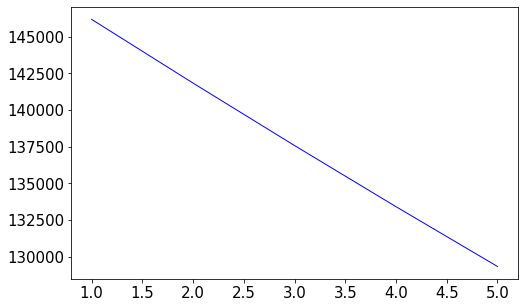

In [18]:
# plot the training loss

model.plot_loss(start_epoch=1)

In [ ]:
# Evaluate using the first 5 data in test dataset

model.evaluate(test_dataset.take(5),return_prediction=False)

In [19]:
# prediction using the first 5 data in test dataset

input_dict = get_input_dict(dataset.take(1))
model.predict(input_dict)

{'pe': array([67602.36697182]),
 'force': array([[[   66.58589675,   -30.49644707,  1779.7605679 ],
         [  130.42466143,    48.09418318,    70.56639397],
         [  -75.81962854,   -22.3077871 ,  1649.1098728 ],
         [ -121.19092991,     4.71005071, -3499.43683456],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0.        ,     0.        ,     0.        ],
         [    0

## Save/load model

**save the trained model**

In [ ]:
# we re-write the descriptor here to empasize that it should be the same one defined above
descriptor = {'name': 'acsf', 
              'cutoff': 6.5,
              'etaG2':[0.01,0.05,0.1,0.5,1,5,10], 
              'etaG4': [0.01], 
              'zeta': [0.08,0.2,1.0,5.0,10.0,50.0,100.0],
              'lambda': [1.0, -1.0]}

save_dir = 'example.tfdnn'
network.save(model,save_dir,descriptor=descriptor)

**Load the trained model for continuous training and prediction**

In [ ]:
imported_model = network.load(save_dir)

# Re-train the model 
loss_weights = {'pe' : 1, 'force' : 1, 'stress': 0.1}

opt = 'Adam'
loss_fun = 'rmse'
scaling = 'std'

model.train(train_dataset, val_dataset, 
            optimizer=opt, 
            loss_fun = loss_fun, 
            batch_size=30, 
            lr=0.02, 
            epochs=5, 
            scaling=scaling, 
            loss_weights=loss_weights, 
            compute_all_loss=True, 
            shuffle=True, 
            append_loss=True)

In [ ]:
train_dataset

In [ ]:
imported_model.evaluate(test_dataset.take(5),return_prediction=False)

In [ ]:
input_dict = get_input_dict(test_dataset.take(5))
imported_model.predict(input_dict)

# Keras layer for energy calculation

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K


fingerprint_num = get_num_fingerprints(descriptor,elements)

zero_initializer = tf.keras.initializers.Zeros()
one_initializer = tf.keras.initializers.Ones()

# build keras DNN model 
neuron_number=[10,10]

input={}
atom_energy_layer={}
hidden_layer={}
activation_function="relu"

for i in range(len(elements)):
    input[i] = keras.layers.Input(shape=[None,fingerprint_num], name="element_"+elements[i]+"_input")
    hidden_layer[i]={}
    hidden_layer[i][0] = keras.layers.Dense(neuron_number[0], 
                                            kernel_initializer=one_initializer, 
                                            bias_initializer=zero_initializer, 
                                            activation=activation_function,
                                            name="element_"+elements[i]+"_hidden1")(input[i])
    for j in range(1,len(neuron_number)):
        hidden_layer[i][j] = keras.layers.Dense(neuron_number[j], 
                                                kernel_initializer=one_initializer, 
                                                bias_initializer=zero_initializer, 
                                                activation=activation_function,
                                                name="element_"+elements[i]+"_hidden"+str(j+1))(hidden_layer[i][j-1])
        
    atom_energy_layer[i] = keras.layers.Dense(1, kernel_initializer=one_initializer, 
                                              bias_initializer=zero_initializer, 
                                              activation="linear",
                                              name="element_"+elements[i]+"_atom_energy")(hidden_layer[i][len(neuron_number)-1])

concat_list=[]
input_list=[]
for i in range(len(elements)):
    concat_list.append(atom_energy_layer[i])
    input_list.append(input[i])
    
if len(elements)>1:
    concat = keras.layers.concatenate(concat_list,axis=1,name="concat_atom_energy") 
    output = keras.layers.Lambda(lambda x: K.sum(x, axis=1))(concat)
else:
    output = keras.layers.Lambda(lambda x: K.sum(x, axis=1))(concat_list[0])    

model = keras.Model(inputs=input_list, outputs=output)

opt = keras.optimizers.Adam(learning_rate=0.01)
#opt = keras.optimizers.SGD(learning_rate=0.01)

model.compile(loss="mae", optimizer=opt)

model.summary()
model.predict(x)

#history = model.fit(x_train_list, y_train, epochs=5,batch_size=1, validation_data=(x_valid_list, y_valid))

history = model.fit(x, y, epochs=5,batch_size=30)